In [365]:
#Code Source: https://www.kaggle.com/dragonoken/churn-modelling-with-pytorch/notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns

### Data Reviewing

In [366]:
os.chdir("C:\\Users\\kusalh\\Documents\\Courses")
BD = pd.read_csv('Courses.csv')
BD.head()

,ID,course,completed,upgraded,gender,country,age,education,job,major,...,completion_year,completion_month,completion_day,completion_hour,completion_minute,upgrade_year,upgrade_month,upgrade_day,upgrade_hour,upgrade_minute
0,284921427,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,284926400,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,284946595,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,285755462,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,285831220,1,1,0,0,0,0,0,0,0,...,2011,5,29,15,58,0,0,0,0,0


[Text(0.5, 0, 'course'),
 Text(1.5, 0, 'completed'),
 Text(2.5, 0, 'gender'),
 Text(3.5, 0, 'country'),
 Text(4.5, 0, 'age'),
 Text(5.5, 0, 'education'),
 Text(6.5, 0, 'job'),
 Text(7.5, 0, 'major'),
 Text(8.5, 0, 'logged_location'),
 Text(9.5, 0, 'withdrew')]

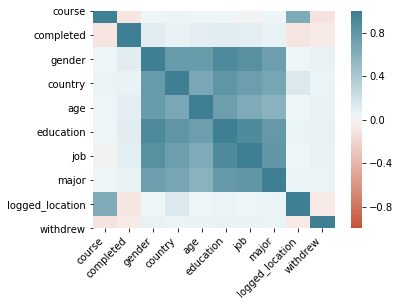

In [367]:
# BD['upgraded'].sum()
corr = DF.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


### Preprocessing 

In [368]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from collections import OrderedDict

### Moving on to Pytorch

In [369]:
# date values are not important unless engineered
DF = BD.drop([
                'ID',
                'upgraded',
#             ], axis=1)
            'registration_year',
            'registration_month',
            'registration_day',
            'registration_hour',
            'registration_minute',
            'withdrawl_year',
            'withdrawl_month',
            'withdrawl_day',
            'withdrawl_hour',
            'withdrawl_minute',
            'completion_year',
            'completion_month',
            'completion_day',
            'completion_hour',
            'completion_minute',
            'upgrade_year',
            'upgrade_month',
            'upgrade_day',
            'upgrade_hour',
            'upgrade_minute'
        ], axis=1)
DF

,course,completed,gender,country,age,education,job,major,logged_location
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,56
4,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
24995,3,0,0,0,0,0,0,0,56
24996,3,0,0,0,0,0,0,0,56
24997,3,0,0,0,0,0,0,0,171
24998,3,0,0,0,0,0,0,0,56


### Feature engineering

In [399]:
withdrew = pd.Series((BD['withdrawl_day'].map(int) != 0).map(int), name="withdrew")
# completed = pd.Series((BD['completion_day'].map(int) != 0).map(int), name="completed")

DF = pd.concat([DF, withdrew], axis=1)

3115

In [371]:
# yer = BD['completion_year'].max()
# mon = BD['completion_month'].max()
# day = BD['completion_day'].max()
# yer = BD['completion_year'][BD['completion_year'] != 0].min()
# mon = BD['completion_month'][BD['completion_month'] != 0].min()
# day = BD['completion_day'][BD['completion_day'] != 0].min()
# yer, mon, day

# Date buckets min and max

# reg: first='2010-1-1' last='2013-12-12'
# wit: first='2011-1-1' last='2013-12-31'
# com: first='2011-1-1' last='2013-12-31'
# upg: first='2011-1-1' last='2013-12-31'



In [372]:
day_of_reg = pd.Series(BD['registration_year'].map(str) + "-" + BD['registration_month'].map(str) + "-" + BD['registration_day'].map(str), name="DoR")
day_of_with = pd.Series(BD['withdrawl_year'].map(str) + "-" + BD['withdrawl_month'].map(str) + "-" + BD['withdrawl_day'].map(str), name="DoW")
day_of_com = pd.Series(BD['completion_year'].map(str) + "-" + BD['completion_month'].map(str) + "-" + BD['completion_day'].map(str), name="DoC")
day_of_upg = pd.Series(BD['upgrade_year'].map(str) + "-" + BD['upgrade_month'].map(str) + "-" + BD['upgrade_day'].map(str), name="DoU")

DF = pd.concat([DF, day_of_reg, day_of_with, day_of_com, day_of_upg], axis=1)

In [452]:
# phases = {'registration': day_of_reg, 'withdrawl':day_of_with, 'completion':day_of_com}
phases = ['registration', 'withdrawl', 'completion', 'upgrade']
buckets = {}

for phase in phases:
    y = phase + '_year'
    m = phase + '_month'
    
    years = BD[y][BD[y] != 0].unique()
    years.sort()
    months = BD[m][BD[m] != 0].unique()
    months.sort()
    bucket = {}
    for year in years:
        for month in months:
            count = len(BD[BD[phase + '_year'] == year][BD[phase + '_month'] == month])
            bucket[str(year) + "_" + str(month)] = count
    buckets[phase] = bucket
buckets

C:\Users\kusalh\AppData\Local\Continuum\miniconda3\envs\course\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


{'registration': {'2010_1': 0,
  '2010_2': 0,
  '2010_3': 0,
  '2010_4': 0,
  '2010_5': 0,
  '2010_6': 0,
  '2010_7': 0,
  '2010_8': 0,
  '2010_11': 0,
  '2010_12': 1,
  '2011_1': 0,
  '2011_2': 3198,
  '2011_3': 2005,
  '2011_4': 3320,
  '2011_5': 1013,
  '2011_6': 459,
  '2011_7': 1,
  '2011_8': 0,
  '2011_11': 2,
  '2011_12': 1249,
  '2012_1': 1871,
  '2012_2': 2161,
  '2012_3': 3820,
  '2012_4': 703,
  '2012_5': 191,
  '2012_6': 2,
  '2012_7': 0,
  '2012_8': 1,
  '2012_11': 0,
  '2012_12': 0,
  '2013_1': 0,
  '2013_2': 2,
  '2013_3': 694,
  '2013_4': 338,
  '2013_5': 2863,
  '2013_6': 671,
  '2013_7': 416,
  '2013_8': 19,
  '2013_11': 0,
  '2013_12': 0},
 'withdrawl': {'2011_1': 0,
  '2011_2': 14,
  '2011_3': 33,
  '2011_4': 194,
  '2011_5': 299,
  '2011_6': 207,
  '2011_7': 88,
  '2011_8': 75,
  '2011_9': 88,
  '2011_10': 64,
  '2011_11': 35,
  '2011_12': 24,
  '2012_1': 69,
  '2012_2': 95,
  '2012_3': 362,
  '2012_4': 277,
  '2012_5': 175,
  '2012_6': 105,
  '2012_7': 70,
  '2012

In [463]:
plt.figure(figsize=(28, 10))

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

[Text(0, 0, '2010_1'),
 Text(0, 0, '2010_11'),
 Text(0, 0, '2010_12'),
 Text(0, 0, '2010_2'),
 Text(0, 0, '2010_3'),
 Text(0, 0, '2010_4'),
 Text(0, 0, '2010_5'),
 Text(0, 0, '2010_6'),
 Text(0, 0, '2010_7'),
 Text(0, 0, '2010_8'),
 Text(0, 0, '2011_1'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8')]

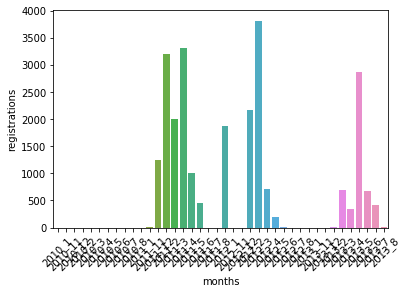

In [466]:
w = buckets['registration']
months = pd.Series([*w.keys()], name='months')
withs = pd.Series([*w.values()], name='registrations')
regs = pd.concat([months, withs], axis=1)
plot = sns.barplot(x="months", y="registrations", data=regs)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_10'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2011_9'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_10'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2012_9'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_10'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8'),
 Text(0, 0, '2013_9')]

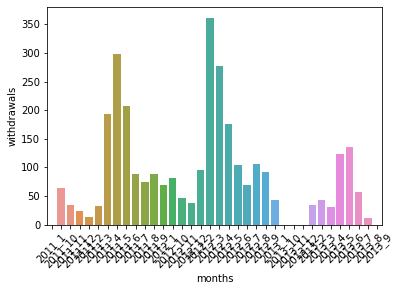

In [450]:
w = buckets['withdrawl']
months = pd.Series([*w.keys()], name='months')
withs = pd.Series([*w.values()], name='withdrawals')
withdrawals = pd.concat([months, withs], axis=1)
withdrawals
plot = sns.barplot(x="months", y="withdrawals", data=withdrawals)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_10'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2011_9'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_10'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2012_9'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_10'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8'),
 Text(0, 0, '2013_9')]

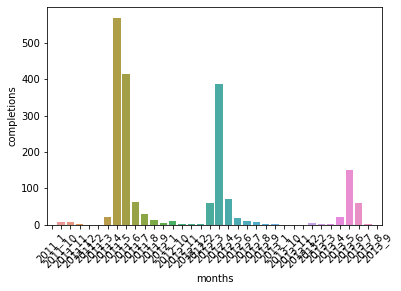

In [451]:
w = buckets['completion']
months = pd.Series([*w.keys()], name='months')
withs = pd.Series([*w.values()], name='completions')
comp = pd.concat([months, withs], axis=1)
plot = sns.barplot(x="months", y="completions", data=comp)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_10'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2011_9'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_10'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2012_9'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_10'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8'),
 Text(0, 0, '2013_9')]

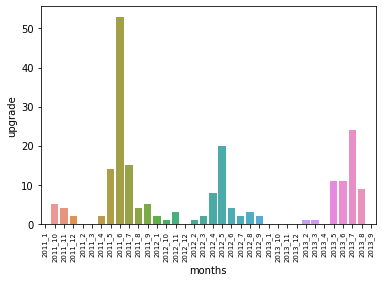

In [459]:
w = buckets['upgrade']
months = pd.Series([*w.keys()], name='months')
withs = pd.Series([*w.values()], name='upgrade')
upgrade = pd.concat([months, withs], axis=1)
plot = sns.barplot(x="months", y="upgrade", data=upgrade)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, fontweight='light', fontsize='x-small')

In [484]:
# Rate calculation data preprocessing

rates = regs.merge(comp, left_on='months', right_on='months').merge(withdrawals, left_on='months', right_on='months').merge(upgrade, left_on='months', right_on='months')
rates['subscribers'] = rates['registrations'].cumsum() - rates['withdrawals'].cumsum()
rates['subscribe_rate'] = rates['registrations'] * 100 / (rates['subscribers'] + rates['withdrawals'] - rates['registrations'])
rates

,months,registrations,completions,withdrawals,upgrade,subscribers,subscribe_rate
0,2011_1,0,0,0,0,0,NaN
1,2011_2,3198,0,14,0,3184,inf
2,2011_3,2005,0,33,0,5156,62.971106
3,2011_4,3320,22,194,2,8282,64.391001
4,2011_5,1013,570,299,14,8996,12.231345
5,2011_6,459,414,207,53,9248,5.102268
6,2011_7,1,63,88,15,9161,0.010813
7,2011_8,0,29,75,4,9086,0.000000
8,2011_11,2,6,35,4,9053,0.022012
9,2011_12,1249,3,24,2,10278,13.796532


In [362]:
features = np.array(DF)
feature_names = DF.columns.tolist()
labels = np.array(BD['upgraded'])
features, feature_names, labels, len(feature_names)

(array([[1, 0, 0, ..., '2012-5-12', '0-0-0', '0-0-0'],
        [1, 0, 0, ..., '2012-5-4', '0-0-0', '0-0-0'],
        [1, 0, 0, ..., '2012-5-20', '0-0-0', '0-0-0'],
        ...,
        [3, 0, 0, ..., '2013-7-10', '0-0-0', '0-0-0'],
        [3, 0, 0, ..., '2013-7-10', '0-0-0', '0-0-0'],
        [3, 0, 0, ..., '2013-7-10', '0-0-0', '0-0-0']], dtype=object),
 ['course',
  'completed',
  'gender',
  'country',
  'age',
  'education',
  'job',
  'major',
  'logged_location',
  'withdrew',
  'DoR',
  'DoW',
  'DoC',
  'DoU'],
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 14)

In [363]:
# important to normalize data
features = (features - features.mean(axis=0, keepdims=True)) / features.std(axis=0, keepdims=True)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

### Create a custom dataset

In [327]:
class MOOC(Dataset):
    def __init__(self):
        global features, labels
        assert features.shape[0] == labels.shape[0], "The lengths of features and labels do not match"

        self.feature_names = feature_names
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels)
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])
    
    def get_feature_names(self):
        return self.feature_names

dataset = MOOC()
len(dataset), dataset[0], len(dataset.get_feature_names())

(25000,
 (tensor([-1.0690, -0.2904, -0.2690, -0.2401, -0.2335, -0.2778, -0.2620, -0.2315,
          -0.8783,  2.6506]),
  tensor(0)),
 10)

### Create 2 dataloaders: a training set loader and a validation set loader.

In [328]:
test_size = 0.1
shuffle = True

# Taking the same proportion of examples from both classes
true_idx = dataset[:][1].eq(1).nonzero().view(-1).long()
false_idx = dataset[:][1].eq(0).nonzero().view(-1).long()

t_new_idx = true_idx[torch.randperm(len(true_idx))] if shuffle else true_idx
f_new_idx = false_idx[torch.randperm(len(false_idx))] if shuffle else false_idx

# trying out matching the number of examples for each class
f_new_idx = f_new_idx[:(len(t_new_idx) // 2) * 2]

t_test_len = int(round(len(t_new_idx) * test_size))
f_test_len = int(round(len(f_new_idx) * test_size))
train_idx = torch.cat((t_new_idx[:len(t_new_idx) - t_test_len], f_new_idx[:len(f_new_idx) - f_test_len]))
validation_idx = torch.cat((t_new_idx[len(t_new_idx) - t_test_len:], f_new_idx[len(f_new_idx) - f_test_len:]))

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

trainloader = DataLoader(dataset, batch_size=len(train_sampler), sampler=train_sampler)
validationloader = DataLoader(dataset, batch_size=len(validation_sampler), sampler=validation_sampler)
len(true_idx), len(false_idx), len(trainloader), len(train_sampler), len(validationloader), len(validation_sampler), next(iter(trainloader))

(209,
 24791,
 1,
 375,
 1,
 42,
 [tensor([[-1.0690,  3.4438, -0.2690,  ..., -0.2315, -0.8783, -0.3773],
          [-1.0690, -0.2904, -0.2690,  ..., -0.2315, -0.8783, -0.3773],
          [ 1.6036, -0.2904, -0.2690,  ..., -0.2315,  0.1519, -0.3773],
          ...,
          [-1.0690,  3.4438, -0.2690,  ..., -0.2315, -0.8783, -0.3773],
          [ 0.2673, -0.2904, -0.2690,  ..., -0.2315,  0.1519, -0.3773],
          [-1.0690, -0.2904, -0.2690,  ..., -0.2315, -0.8783, -0.3773]]),
  tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
          1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
          0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
          0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
          1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
          0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
          0, 1, 1, 0, 1, 1

## Building the model

In [329]:
class ANN(nn.Module):
    def __init__(self, input_dim = 9, output_dim = 1):
        super(ANN, self).__init__()
    
        # Input Layer (784) -> 784
        self.fc1 = nn.Linear(input_dim, 200)
        # 64 -> 64
        self.fc2 = nn.Linear(200, 200)
        # 64 -> 32
        self.fc3 = nn.Linear(200, 100)
        # 32 -> 32
        self.fc4 = nn.Linear(100, 100)
        # 32 -> output layer(10)
        self.output_layer = nn.Linear(100,1)
        # Dropout Layer (20%) to reduce overfitting
        self.dropout = nn.Dropout(0.2)
    
    # Feed Forward Function
    def forward(self, x):
        
        # Add ReLU activation function to each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # Don't add any ReLU activation function to Last Output Layer
        x = self.output_layer(x)
        
        # Return the created model
        return nn.Sigmoid()(x)

In [330]:
# Create the Neural Network Model
model = ANN(input_dim = 10, output_dim = 1)
# Print its architecture
print(model)

ANN(
  (fc1): Linear(in_features=10, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [331]:
import torch
import torch.utils.data
from torch.autograd import Variable

### Training the model

In [332]:
import torch.optim as optim
# specify loss function
loss_fn = nn.BCELoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9,nesterov = True)

In [333]:
# Define epochs (between 20-50)
epochs = 1000

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Set the training mode ON -> Activate Dropout Layers
model.train() # prepare model for training

for epoch in range(epochs):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    # Calculate Accuracy         
    correct = 0
    total = 0
    for data,target in trainloader:
        data = Variable(data).float()
        target = Variable(target).type(torch.FloatTensor)
        #print("Target = ",target[0].item())
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        predicted = (torch.round(output.data[0]))
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()

        # calculate the loss
        loss = loss_fn(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # calculate average training loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.4f}\t Acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 2 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 3 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 4 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 5 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 6 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 7 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 8 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 9 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 10 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 11 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 12 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 13 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 14 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 15 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 16 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 17 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 18 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 19 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 20 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 21 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 22 	Training Loss: 0.2067	 Acc: 50.1

Epoch: 180 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 181 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 182 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 183 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 184 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 185 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 186 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 187 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 188 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 189 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 190 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 191 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 192 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 193 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 194 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 195 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 196 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 197 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 198 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 199 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 200 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 201 	T

Epoch: 359 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 360 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 361 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 362 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 363 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 364 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 365 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 366 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 367 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 368 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 369 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 370 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 371 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 372 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 373 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 374 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 375 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 376 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 377 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 378 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 379 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 380 	T

Epoch: 537 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 538 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 539 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 540 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 541 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 542 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 543 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 544 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 545 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 546 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 547 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 548 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 549 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 550 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 551 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 552 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 553 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 554 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 555 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 556 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 557 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 558 	T

Epoch: 712 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 713 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 714 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 715 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 716 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 717 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 718 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 719 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 720 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 721 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 722 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 723 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 724 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 725 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 726 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 727 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 728 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 729 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 730 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 731 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 732 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 733 	T

Epoch: 893 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 894 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 895 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 896 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 897 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 898 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 899 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 900 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 901 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 902 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 903 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 904 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 905 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 906 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 907 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 908 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 909 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 910 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 911 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 912 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 913 	Training Loss: 0.2067	 Acc: 50.13%
Epoch: 914 	T

# ## Visualising the training process

In [334]:
import matplotlib.pyplot as plt

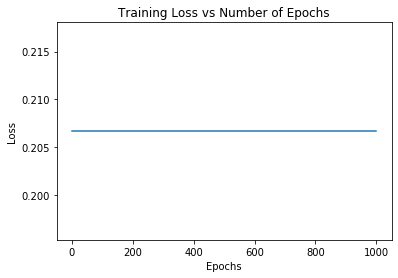

In [335]:
plt.plot(epoch_list,train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Number of Epochs")
plt.show()

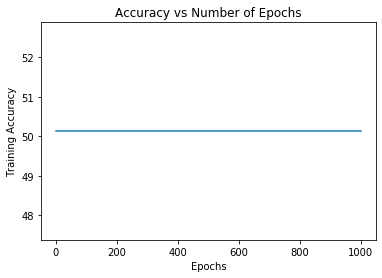

In [336]:
plt.plot(epoch_list,train_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.show()

In [337]:
correct = 0
total = 0
val_loss = 0
model.eval() # Required for Evaluation/Test
with torch.no_grad():
    for data, target in validationloader:

        # Convert our images and labels to Variables to accumulate Gradients
        data = Variable(data).float()
        target = Variable(target).type(torch.FloatTensor)

        # Predict Output
        output = model(data)

        # Calculate Loss
        loss = loss_fn(output, target)
        val_loss += loss.item()*data.size(0)
        # Get predictions from the maximum value
        predicted = (torch.round(output.data[0]))

        # Total number of labels
        total += len(target)

        # Total correct predictions
        correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(validationloader.dataset)
    accuracy = 100 * correct/ float(total)
print("Accuracy = ",accuracy.item() * 0.01)

Accuracy =  0.5
